In [2]:
%matplotlib inline
import sys                                 
import os                                  
import numpy as np                         
import matplotlib.pyplot as plt  
import pickle
from matplotlib.backends.backend_pdf import PdfPages               
                                           
caffe_root = os.environ["CAFFE_ROOT"]      
os.chdir(caffe_root)                       
print caffe_root                           
sys.path.insert(0, caffe_root + 'python')  
import caffe                               

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 21 days
Vendor:  Continuum Analytics, Inc.


/home/maohz12/pruning/


Package: mkl
Message: trial mode expires in 21 days


In [3]:
prototxt = '/home/maohz12/pruning/3_prototxt_solver/L2/train_val.prototxt'      
caffemodel = '/home/maohz12/pruning/4_model_checkpoint/alexnet/alexnet9x.caffemodel'    
# caffemodel = '/home/maohz12/pruning/4_model_checkpoint/bvlc_alexnet.caffemodel' 
dir_t = '/home/maohz12/pruning/2_results/kmeans/alexnet/'
codebook = pickle.load(open(dir_t + 'codebook.pkl'))

codebook_history = pickle.load(open(dir_t + 'codebook_history.pkl'))
codebook_4std = pickle.load(open(dir_t + 'codebook_4std.pkl'))
codebook_history_4std = pickle.load(open(dir_t + 'codebook_history_4std.pkl')) 
net = caffe.Net(prototxt, caffemodel, caffe.TEST)                                         

In [4]:
print codebook.keys()
# print codebook
for key in codebook.keys():
    print codebook[key].size

['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4']
16
16
16
64
64
64
64
64


conv1


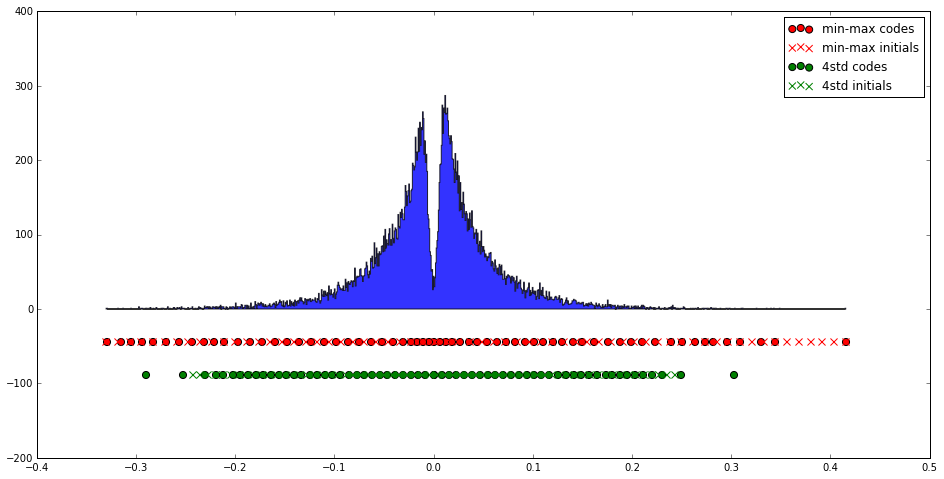

conv3


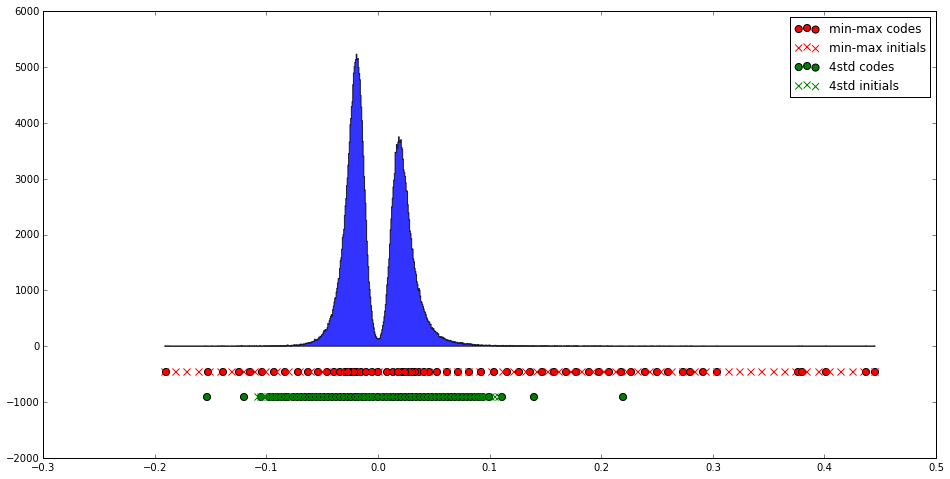

conv5


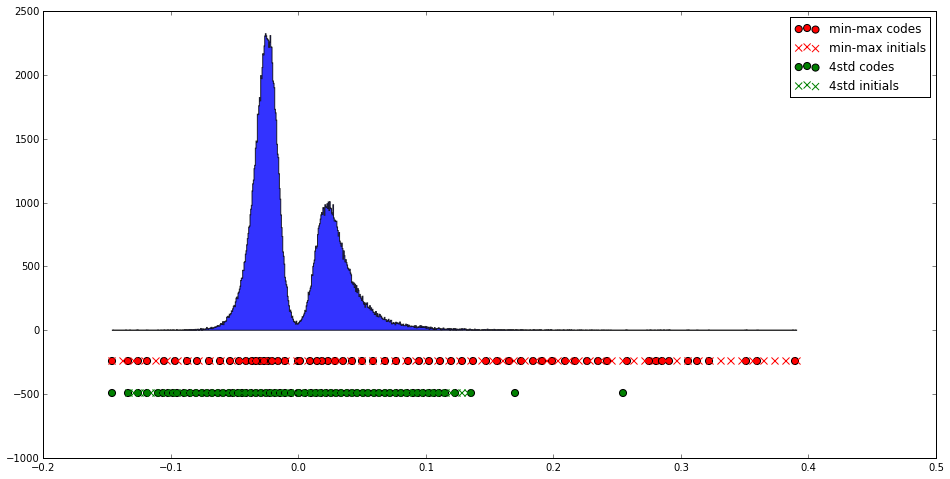

fc6


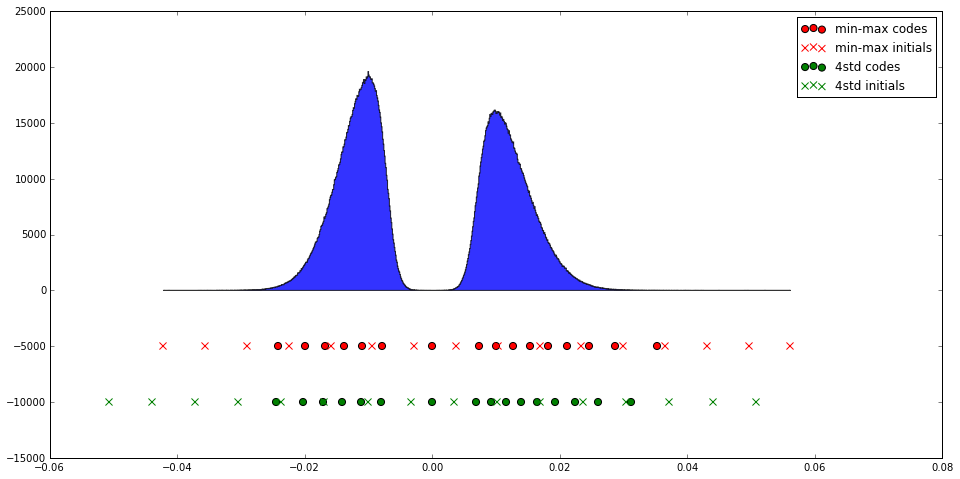

fc7


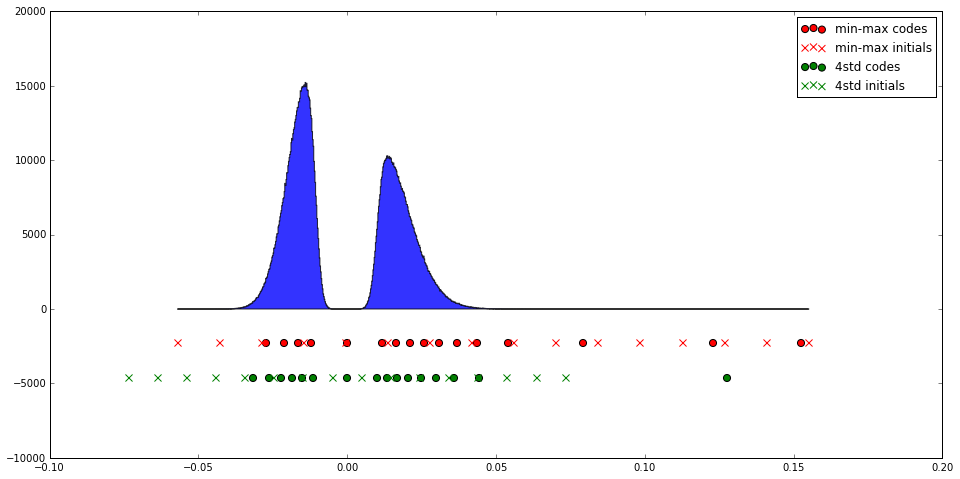

fc8


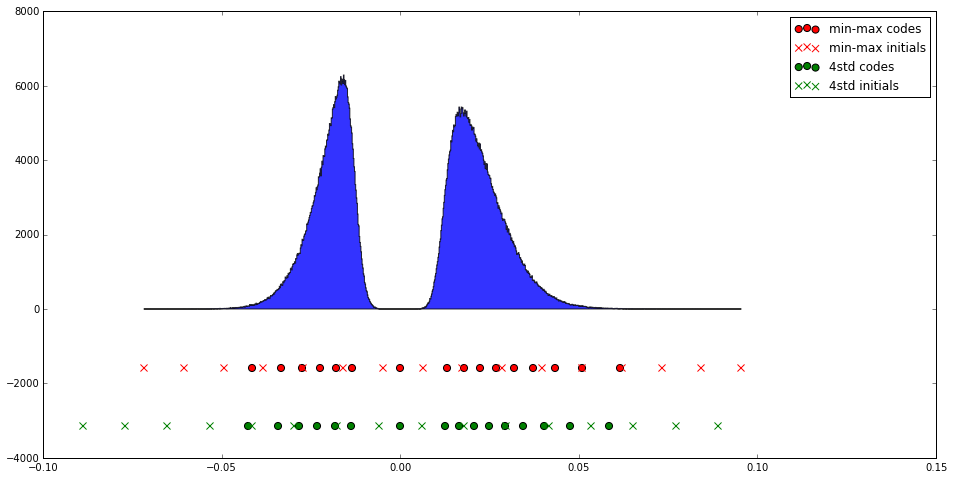

In [5]:

layers = filter(lambda x:'conv' in x or 'fc' in x, net.params.keys())
layers= ['conv1', 'conv3', 'conv5','fc6', 'fc7','fc8']

for i,layer in enumerate(layers):
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
   
    numBins = 1024  
    code = codebook[layer]
    min_W = np.min(W)                                       
    max_W = np.max(W)                
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(min_W, max_W, num_c) 
    print layer
    plt.figure(figsize=(16,8))    
    # std = np.std(W)
    plt.hist(W.flatten(), numBins, color='blue', alpha=0.8, histtype='stepfilled') 
    shift = 0.0015 * W.size
    code_dot=plt.scatter(code, np.zeros(code.shape)-shift, marker='o', c='red', s=50)
    initial_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-shift, marker='x', c='red', s=50)
    
    # 4std
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
      
    code = codebook_4std[layer]

    std = np.std(W)          
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(std * -4, std * 4, num_c)  
      
    # std = np.std(W)
    # plt.hist(W.flatten(), numBins, color='blue', alpha=0.8) 
    code_4std_dot=plt.scatter(code, np.zeros(code.shape)-2*shift, marker='o', c='green', s=50)
    initial_4std_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-2*shift, marker='x', c='green', s=50)
    
    plt.legend([code_dot, initial_cross, code_4std_dot, initial_4std_cross], 
               ['min-max codes', 'min-max initials', '4std codes', '4std initials'])
    plt.show() 

fc6


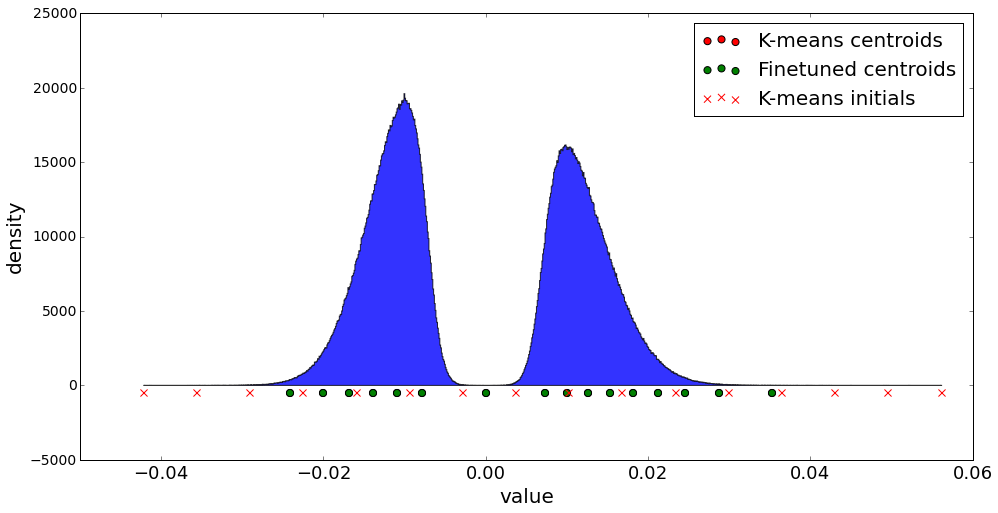

In [6]:
layers = ['fc6']
pp = PdfPages('distribution_of_codebook.pdf') 
codebook_finetune = pickle.load(open(dir_t + 'codebook_snapshot/codebook401'))
for i,layer in enumerate(layers):
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
   
    numBins = 1024  
    code = codebook[layer]
    code_finetune = codebook_finetune[layer]
    min_W = np.min(W)                                       
    max_W = np.max(W)                
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(min_W, max_W, num_c) 
    print layer
    fig=plt.figure(figsize=(16,8)) 
    ax = fig.add_subplot(1,1,1)
    # std = np.std(W)
    plt.xlim(-0.05,0.06)
    ax.hist(W.flatten(), numBins, color='blue', alpha=0.8, histtype='stepfilled') 
    shift = 0.00015 * W.size
    code_dot=plt.scatter(code, np.zeros(code.shape)-shift, marker='o', c='red', s=50)
    code_finetune_dot=plt.scatter(code_finetune, np.zeros(code_finetune.shape)-shift, marker='o', c='green', s=50)
    initial_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-shift, marker='x', c='red', s=50)
    
    # 4std
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
      
    code = codebook_4std[layer]

    std = np.std(W)          
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(std * -4, std * 4, num_c)  
      
    # std = np.std(W)
    # plt.hist(W.flatten(), numBins, color='blue', alpha=0.8) 
    #code_4std_dot=plt.scatter(code, np.zeros(code.shape)-2*shift, marker='o', c='green', s=50)
    #initial_4std_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-2*shift, marker='x', c='green', s=50)
    
    ax.legend([code_dot, code_finetune_dot, initial_cross],# code_4std_dot, initial_4std_cross], 
               ['K-means centroids', 'Finetuned centroids', 'K-means initials'], fontsize=20)#, '4std codes', '4std initials'])
    plt.xlabel('value',fontsize=20)
    plt.ylabel('density',fontsize=20)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        # specify integer or one of preset strings, e.g.
        #tick.label.set_fontsize('x-small') 
    for tick in ax.yaxis.get_major_ticks():  
        tick.label.set_fontsize(14) 
        # tick.label.set_rotation('vertical')
   
    plt.savefig(pp, format='pdf')
    pp.close()
    plt.show() 

In [7]:
codebook_finetune = pickle.load(open(dir_t + 'codebook_snapshot/codebook1'))
codebook_finetune['fc6']

array([ 0.        , -0.02415823, -0.01999678, -0.01681521, -0.0138747 ,
       -0.01096613, -0.00791372,  0.00732811,  0.01002056,  0.0126092 ,
        0.01528922,  0.01811778,  0.02117264,  0.0245834 ,  0.02871666,
        0.03522838])

In [8]:
codebook_finetune = pickle.load(open(dir_t + 'codebook_snapshot/codebook501'))
codebook_finetune['fc6']

array([ 0.        , -0.02415869, -0.01999716, -0.01681541, -0.01387478,
       -0.01096613, -0.00791348,  0.0073279 ,  0.01002058,  0.01260929,
        0.0152894 ,  0.01811785,  0.02117273,  0.02458356,  0.02871612,
        0.03523143])

conv3


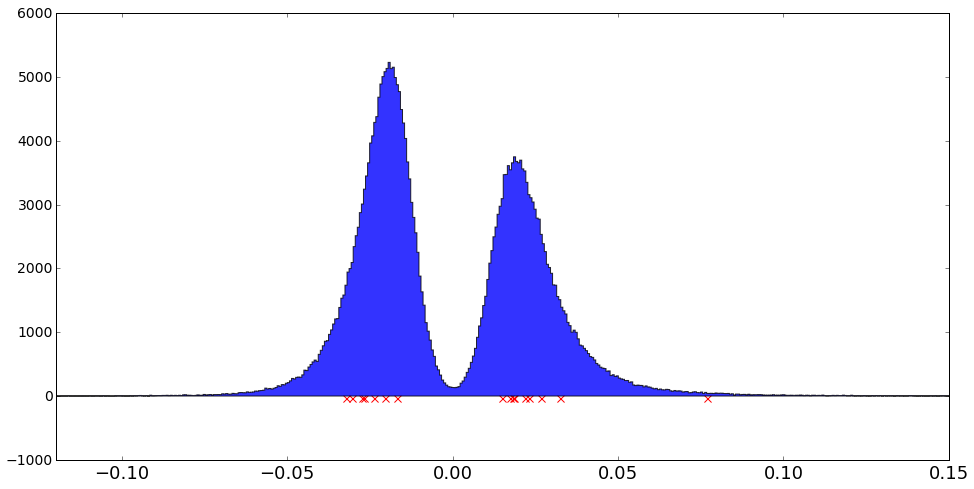

In [20]:
layers = ['conv3']
pp = PdfPages('distribution_of_random.pdf') 
# codebook_finetune = pickle.load(open(dir_t + 'codebook_snapshot/codebook401'))
for i,layer in enumerate(layers):
    W = net.params[layer][0].data.flatten()
    W = W[np.where(W!=0)] 
   
    numBins = 1024  
    code = codebook[layer]
    code_finetune = codebook_finetune[layer]
    min_W = np.min(W)                                       
    max_W = np.max(W)                
    num_c = 2**np.ceil(np.log2(code.size))
    
    # initial_uni = np.linspace(min_W, max_W, num_c) 
    initial_uni = W[np.random.randint(0, high=W.size, size=16)]
    print layer
    fig=plt.figure(figsize=(16,8)) 
    ax = fig.add_subplot(1,1,1)
    # std = np.std(W)
    plt.xlim(-0.12,0.15)
    ax.hist(W.flatten(), numBins, color='blue', alpha=0.8, histtype='stepfilled') 
    shift = 0.00015 * W.size
    # code_dot=plt.scatter(code, np.zeros(code.shape)-shift, marker='o', c='red', s=50)
    # code_finetune_dot=plt.scatter(code_finetune, np.zeros(code_finetune.shape)-shift, marker='o', c='green', s=50)
    initial_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-shift, marker='x', c='red', s=50)
    
    # 4std
    #W = net.params[layer][0].data   
    #W = W[np.where(W!=0)] 
      
    #code = codebook_4std[layer]

    #std = np.std(W)          
    #num_c = 2**np.ceil(np.log2(code.size))
    #initial_uni = np.linspace(std * -4, std * 4, num_c)  
      
    # std = np.std(W)
    # plt.hist(W.flatten(), numBins, color='blue', alpha=0.8) 
    #code_4std_dot=plt.scatter(code, np.zeros(code.shape)-2*shift, marker='o', c='green', s=50)
    #initial_4std_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-2*shift, marker='x', c='green', s=50)
    
    #ax.legend([code_dot, code_finetune_dot, initial_cross],# code_4std_dot, initial_4std_cross], 
    #           ['K-means centroids', 'Finetuned centroids', 'K-means initials'], fontsize=20)#, '4std codes', '4std initials'])
    #plt.xlabel('value',fontsize=20)
    #plt.ylabel('density',fontsize=20)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        # specify integer or one of preset strings, e.g.
        #tick.label.set_fontsize('x-small') 
    for tick in ax.yaxis.get_major_ticks():  
        tick.label.set_fontsize(14) 
        # tick.label.set_rotation('vertical')
   
    plt.savefig(pp, format='pdf')
    pp.close()
    plt.show() 

In [14]:
help(np.random.randint)

Help on built-in function randint:

randint(...)
    randint(low, high=None, size=None)
    
    Return random integers from `low` (inclusive) to `high` (exclusive).
    
    Return random integers from the "discrete uniform" distribution in the
    "half-open" interval [`low`, `high`). If `high` is None (the default),
    then results are from [0, `low`).
    
    Parameters
    ----------
    low : int
        Lowest (signed) integer to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is the *highest* such
        integer).
    high : int, optional
        If provided, one above the largest (signed) integer to be drawn
        from the distribution (see above for behavior if ``high=None``).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    
    Returns
    -------
    